In [33]:
import pickle
import math
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from my_utils import print_red, print_cyan, print_green

"""
Inputs:
df of net load

Outputs:
CFD plot and VRE event df for fingerprint matching
"""

def fast_cfd(df_netload):
    #kolla på diffen av detta
    df_freq = pd.DataFrame()
    output = {}
    dfrows=df_netload.index
    net_loads_array = np.array(df_netload["net load"].values)
    for amp in amps:
        # initiate variables before row loop
        d = {'net load': net_load,'count1':0,'count2':0}
        df_netload = pd.DataFrame(data=d)
        previous_row = dfrows[0]
        previous_net_load_val = net_loads_array[0]
        amp_positive = amp>=0
        amp_negative = not amp_positive
        for i_r, row in enumerate(dfrows):
            #net_load_val = df_netload.at[row,'net load']
            net_load_val = net_loads_array[i_r]
            netload_greater_than_amp = net_load_val>=amp
            netload_smaller_than_amp = not netload_greater_than_amp
            previous_netload_greater_than_amp = previous_net_load_val>=amp
            previous_netload_smaller_than_amp = not previous_netload_greater_than_amp
            if amp_positive and netload_greater_than_amp:
    #            df_netload.set_value(row, 'count1', df_netload.at[previous_row,'count1']+1)
                df_netload.at[row, 'count1']= df_netload.at[previous_row,'count1']+1
            elif amp_negative and netload_smaller_than_amp:
    #            df_netload.set_value(row, 'count1', df_netload.at[previous_row,'count1']+1)
                df_netload.at[row, 'count1']= df_netload.at[previous_row,'count1']+1
    #varje periods längd vid sluttillfället
            if amp_positive and previous_netload_greater_than_amp and netload_smaller_than_amp:
    #            df_netload.set_value(previous_row, 'count2', df_netload.at[previous_row,'count1'])
                df_netload.at[previous_row, 'count2']= df_netload.at[previous_row,'count1']
            elif amp_negative and previous_netload_smaller_than_amp and netload_greater_than_amp:
    #            df_netload.set_value(previous_row, 'count2', df_netload.at[previous_row,'count1'])
                df_netload.at[previous_row, 'count2']= df_netload.at[previous_row,'count1']
            previous_row=row
            previous_net_load_val = net_load_val

        s=df_netload.count2.value_counts()
        df_freq=pd.DataFrame(data=s)
    #    s_form=list(s)
        output[amp]=df_freq
    #df_out=pd.DataFrame(data=output, index=[amp])
    #df_out = pd.DataFrame()
    df_out_tot = pd.DataFrame()
    #output2 = {}
    for amp in amps:
        df_out = output[amp]
        df_out = df_out.iloc[1:]
        df_out.index.name = 'Duration'
        df_out = pd.concat([df_out], keys=[amp], names=['Amplitude'])
        df_out.rename(columns={'count2':'Occurences'}, inplace=True)
        df_out_tot=df_out_tot.append(df_out)
    #    output2[amp] = df_out
    #df_out[0]
    return df_out_tot


def slow_cfd(df_netload):
    #kolla på diffen av detta
    df_freq = pd.DataFrame()
    output = {}
    for amp in amps:
        d = {'net load': net_load,'count1':0,'count2':0}
        df_netload = pd.DataFrame(data=d)
        s=[]
        dfrows=df_netload.index ## att plocka ut .index i förväg är toppen, men kan göras utanför loopen
        rowbefore=dfrows[0]
    #ökande siffra när värde över amp
        for row in dfrows:
            ## 1: (detta sparade ca 90s per år)
            ## det är generellt långsamt att läsa och ändra värden i en DataFrame jämfört med listor eller arrays
            ## -> bäst att försöka läsa värden från df så få gånger så möjligt
            ## vi kan spara df_netload["net load"].values i en lista eller array i förväg och läsa därifrån istället
            ## net_loads_array = np.array(df_netload["net load"].values)
            ## så kan vi läsa ut varje rads netload genom net_loads_array[i]
            ##
            ## 2: (detta sparade ca 250s per år, varav det absolut mesta från den första delen)
            ## a) i if-satserna letar vi efter netload[row] flera gånger (och för varje amp) trots att det är samma värde varje gång
            ## snabbare att för varje row spara undan net_load_val=net_loads_array[i] och använda det timvärdet direkt
            ## b) vi kan också göra jämförelserna amp>0 etc en gång och spara True/False istället för att utvärdera olikheten flera gånger
            ## netload_greater_than_amp = net_load_val>=amp
            ## och sedan
            ## if amp_positive and netload_greater_than_amp:
            if amp>0 and df_netload.at[row,'net load']>amp:
    #            df_netload.set_value(row, 'count1', df_netload.at[rowbefore,'count1']+1)
                df_netload.at[row, 'count1']= df_netload.at[rowbefore,'count1']+1
            elif amp<0 and df_netload.at[row,'net load']<amp:
    #            df_netload.set_value(row, 'count1', df_netload.at[rowbefore,'count1']+1)
                df_netload.at[row, 'count1']= df_netload.at[rowbefore,'count1']+1
            rowbefore=row

        rowbefore=dfrows[0]
    #varje periods längd vid sluttillfället
        for row in dfrows:
            if amp >0 and df_netload.at[rowbefore,'net load']>amp and df_netload.at[row,'net load']<amp:
    #            df_netload.set_value(rowbefore, 'count2', df_netload.at[rowbefore,'count1'])
                df_netload.at[rowbefore, 'count2']= df_netload.at[rowbefore,'count1']
            elif amp<0 and df_netload.at[rowbefore,'net load']<amp and df_netload.at[row,'net load']>amp:
    #            df_netload.set_value(rowbefore, 'count2', df_netload.at[rowbefore,'count1'])
                df_netload.at[rowbefore, 'count2']= df_netload.at[rowbefore,'count1']
            rowbefore=row

        s=df_netload.count2.value_counts()
        df_freq=pd.DataFrame(data=s)
    #    s_form=list(s)
        output[amp]=df_freq
    #df_out=pd.DataFrame(data=output, index=[amp])
    #df_out = pd.DataFrame()
    df_out_tot = pd.DataFrame()
    #output2 = {}
    for amp in amps:
        df_out = output[amp]
        df_out = df_out.iloc[1:]
        df_out.index.name = 'Duration'
        df_out = pd.concat([df_out], keys=[amp], names=['Amplitude'])
        df_out.rename(columns={'count2':'Occurences'}, inplace=True)
        df_out_tot=df_out_tot.append(df_out)
    #    output2[amp] = df_out
    #df_out[0]
    return df_out_tot


#data = pickle.load(open("PickleJar\\netload_components_1980-2019.pickle","rb"))
data = pickle.load(open("PickleJar\\netload_components_1980.pickle","rb"))
VRE_profiles = data["VRE_profiles"]
load = data["load"]
cap = data["cap"]
print(VRE_profiles.shape, load.shape, cap.shape)
#VRE_profiles
#load
#cap
if type(load)==dict:
    load_list = []
    for year, load in load.items():
        load_list += list(load)
    load = np.array(load_list)
net_load = -(VRE_profiles*cap).sum(axis=1) + load.sum(axis=1)
net_load

(8784, 120) (8784, 6) (51,)


0       105.020281
1       106.067851
2       106.343220
3       109.522208
4       117.309409
           ...    
8779     85.915130
8780     75.618221
8781     66.263747
8782     58.806286
8783     55.914148
Length: 8784, dtype: float64

In [23]:
#net_load=((-1)*df_disp['bat_ch'])
#net_load=(df_disp['WG_peak'])
d = {'net load': net_load,'count1':0,'count2':0}
df_netload = pd.DataFrame(data=d)
#maxind, maxval = max(net_load, key=lambda item: item[1])
maxval=int(math.ceil(net_load.max()))
minval=int(math.floor(net_load.min()))
amps = np.arange(minval, maxval, 0.1).tolist()
print("length of amps:",len(amps))
print(df_netload, minval,maxval)

length of amps: 3370
        net load  count1  count2
0     105.020281       0       0
1     106.067851       0       0
2     106.343220       0       0
3     109.522208       0       0
4     117.309409       0       0
...          ...     ...     ...
8779   85.915130       0       0
8780   75.618221       0       0
8781   66.263747       0       0
8782   58.806286       0       0
8783   55.914148       0       0

[8784 rows x 3 columns] -143 194


In [34]:
pickle_read_name = ""
pickle_dump_name = r"PickleJar\1980-2019_CFD_netload_df.pickle"
if pickle_read_name:
    df_out_tot = pickle.load(open())
else:
    start_time = timer()
    df_out_tot = fast_cfd(df_netload) # 248s at 1 year then more changes and now 156-157s at 1 year
    #df_out_tot = slow_cfd(df_netload) # 500-523s at 1 year
    end_time = timer()
    print(f"elapsed time = {round(end_time - start_time,1)}")

elapsed time = 155.6


In [5]:
if pickle_dump_name: pickle.dump(df_out_tot, open(pickle_dump_name,'wb'))

In [29]:
df_reset = df_out_tot.reset_index()
df_reset.columns = ['Amplitude', 'Duration', 'Occurrence']
df_pivot=df_reset.pivot('Amplitude', 'Duration')

X=df_pivot.columns.levels[1].values
Y=df_pivot.index.values
Z=df_pivot.values
#df1['A'] = df1['A'].apply(lambda x: [y if y <= 9 else 11 for y in x])
Znetload=np.where(Z > 50, 50, Z)
Xnetload,Ynetload = np.meshgrid(X, Y)


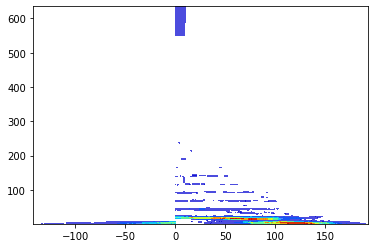

In [30]:
import matplotlib.pyplot as plt
plt.contourf(Ynetload, Xnetload, Znetload, alpha=0.7, cmap=plt.cm.jet);
#plt.show()

In [28]:
plt.savefig("figures\\cfd_1980_fastfunc.png")

<Figure size 432x288 with 0 Axes>